# Intro to Argovis' Grid API

Argovis offers a growing list of gridded products, indexed and downloadable through its API. In this notebook, we'll illustrate some basic operations and handling of this data.

> **This is a beta product!**
> Argovis' new API is currently undergoing heavy development. Therefore, everything in these notebooks should be understood as a technical preview only; implementation details may change before a 
stable release is made. Please send feedback and ideas to argovis@colorado.edu, and see the API docs as they evolve at https://argovis-api.colorado.edu/docs/.

## Setup

In addition to importing a few python packages, make sure to plug in your Argovis API key for `API_KEY` in the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [1]:
import requests, xarray, pandas, math, datetime
import numpy as np
from datetime import datetime, timedelta

API_KEY=''

## Downloading Gridded Data

Argovis offers gridded data at its `/grids` endpoint. Available query string parameters are:

 - `gridName` (mandatory, one of rgTempTotal, rgPsalTotal, ohc): name of gridded product to search.
 - `startDate` (mandatory, format YYYY-MM-DDTHH:MM:SSZ at GMT0): beginning of time window to query.
 - `endDate` (mandatory, format YYYY-MM-DDTHH:MM:SSZ at GMT0): end of time window to query.
 - `polygon` (mandatory, format [[lon0,lat0],[lon1,lat1],...,[lonN,latN],[lon0,lat0]]): geographical region to query.
 - `presRange` (optional, format minimum_pressure,maximum_pressure): pressure window to filter for.

#### Please note that if the spatiotemporal region of interest is too large, the API request will fail. This will be handled in a future version of the notebook (splitting the user's request in small queries), so that users can access data in regions/time windows as large as needed.

As noted, `gridName`, `startDate`, `endDate` and `polygon` are all required for downloading gridded data, but we can get just the metadata record that describes some high-level information about each grid by providing only the `gridName` parameter:


In [2]:
params = {
  "gridName": 'rgTempTotal',
}

r = requests.get('https://argovis-api.colorado.edu/grids', params=params, headers={'x-argokey': API_KEY})
print(r.json())

{'_id': 'rgTempTotal', 'units': 'degree celcius (ITS-90)', 'levels': [2.5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 182.5, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 462.5, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1412.5, 1500, 1600, 1700, 1800, 1900, 1975], 'date_added': '2022-04-27T23:07:27.943Z', 'lonrange': [-179.5, 179.5], 'latrange': [-64.5, 79.5], 'timerange': ['2004-01-15T00:00:00.000Z', '2018-12-15T00:00:00.000Z'], 'loncell': 1, 'latcell': 1}


We see information about the Roemmich-Gilson Argo climatology, like what pressure levels are present, what the minimum and maximum of latitude, longitude and time is in the grid, and soforth.

Let's try a simple request to download a piece of data from this climatology, a 10 degree box over the North Atlantic from the first quarter of 2012:

In [3]:
params = {
  "gridName": 'rgTempTotal',
  "startDate": '2012-01-01T00:00:00Z',
  "endDate": '2012-04-01T00:00:00Z',
  "polygon": '[[-66.621094,42.163403],[-71.367188,40.580585],[-74.003906,37.439974],[-75.058594,35.029996],[-79.453125,32.249974],[-80.15625,29.993002],[-78.75,23.725012],[-73.828125,21.289374],[-70.3125,20.797201],[-67.5,19.47695],[-64.160156,19.47695],[-66.621094,42.163403]]'
}

r = requests.get('https://argovis-api.colorado.edu/grids', params=params, headers={'x-argokey': API_KEY})
rgdata = r.json()

(If you need help constructing a polygon, try the following:

  - visit argovis.colorado.edu
  - draw a shape
  - click on the purple shaded area of the region of interest (not on a dot)
  - from the pop up window, go "to Selection page"
  - from the url of the selection shape, copy the shape, i.e. [copy_all_this_inside_outer_brackets] after 'shape=')


Like most Argovis API requests, you get a list of documents matching your query. Let's have a look at the first record in what the API returned to us:

In [4]:
rgdata[0]

{'_id': 'rgTempTotal',
 'units': 'degree celcius (ITS-90)',
 'levels': [2.5,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  182.5,
  200,
  220,
  240,
  260,
  280,
  300,
  320,
  340,
  360,
  380,
  400,
  420,
  440,
  462.5,
  500,
  550,
  600,
  650,
  700,
  750,
  800,
  850,
  900,
  950,
  1000,
  1050,
  1100,
  1150,
  1200,
  1250,
  1300,
  1350,
  1412.5,
  1500,
  1600,
  1700,
  1800,
  1900,
  1975],
 'date_added': '2022-04-27T23:07:27.943Z',
 'lonrange': [-179.5, 179.5],
 'latrange': [-64.5, 79.5],
 'timerange': ['2004-01-15T00:00:00.000Z', '2018-12-15T00:00:00.000Z'],
 'loncell': 1,
 'latcell': 1}

The first object in a request to `/grids` is always the appropriate *metadata record* for the grid, the same as what you got from `/grids?gridName=rgTempTotal` above. We automatically include it at the front of the full data requests as it is necessary for interpreting that data, as we'll see immediately below.

All the records returned by `/grids` after the first specify the actual data we wanted; let's have a look at one of them:

In [5]:
rgdata[1]

{'_id': '6264911daa7c85060714796f',
 'g': {'type': 'Point', 'coordinates': [-79.5, 27.5]},
 't': '2012-03-15T00:00:00.000Z',
 'd': [24.516001,
  24.459999,
  24.309,
  24.151001,
  23.873999,
  23.537001,
  23.18,
  22.799999,
  22.447001,
  22.127001,
  21.856001,
  21.453999,
  21.112,
  20.784,
  20.486,
  20.174999,
  19.878,
  19.635,
  19.326,
  18.858999,
  18.379,
  18.028,
  17.699001,
  17.446001,
  17.181999,
  16.962,
  16.737999,
  16.530001,
  16.352001,
  16.210001,
  16.067999,
  15.958,
  15.700001,
  15.1,
  14.091,
  12.921,
  11.723,
  10.567,
  9.458,
  8.373,
  7.483,
  6.433,
  5.701,
  5.129,
  4.678,
  4.544,
  4.553,
  4.554,
  4.571,
  4.452,
  4.338,
  4.245,
  4.129,
  4.025,
  3.938,
  3.845,
  3.796,
  3.756]}

By default, Argovis returns gridded data in a *profile-like* structure: this record, located in space by its `g` key (for geolocation) and time by its `t` key, contains the grid points for all corresponding depths in its `d` (for data) key. To interpret the list of numbers, compare it entry-by-entry to the `levels` key in the metadata record; for example, the two records printed above indicate that the temperature at these coordinates and 10 dbar depth is 24.459999.

## Ingestion by xarray

Xarray is a familiar pythonic data structure; we can transform a raw API response to an xarray with a helper similar to the following.

In [6]:
def xargrid(grid):
    # given the json response <grid> of a request to /grids,
    # return an xarray object with coordinates time, lat, lon, depth, and measurement value.
    
    lat = []
    lon = []
    time = []
    pres = []
    meas = []
    for p in grid[1:]:
        for i, e in enumerate(p['d']):
            lon.append(p['g']['coordinates'][0])
            lat.append(p['g']['coordinates'][1])
            # convert a string to a date (zeros to check at the end of date)
            time.append(datetime.strptime(p['t'], '%Y-%m-%dT%H:%M:%S.%fZ'))
            meas.append(p['d'][i])
            pres.append(grid[0]['levels'][i])
            
    df = pandas.DataFrame({"latitude": lat, 
                           "longitude": lon, 
                           "time": time, 
                           "pressure": pres, 
                           "measurement": meas}).set_index(["latitude","longitude","time","pressure"])
    return df.to_xarray()
    
ds = xargrid(rgdata)

Now we can do all the usual xarray operations; lets see what the ranges of our coordinate variables are:

In [7]:
print('latitudes:',ds['latitude'].data)
print('longitudes:',ds['longitude'].data)
print('times:',ds['time'].data)
print('pressures:',ds['pressure'].data)

latitudes: [19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5
 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5]
longitudes: [-79.5 -78.5 -77.5 -76.5 -75.5 -74.5 -73.5 -72.5 -71.5 -70.5 -69.5 -68.5
 -67.5 -66.5 -65.5 -64.5]
times: ['2012-01-15T00:00:00.000000000' '2012-02-15T00:00:00.000000000'
 '2012-03-15T00:00:00.000000000']
pressures: [   2.5   10.    20.    30.    40.    50.    60.    70.    80.    90.
  100.   110.   120.   130.   140.   150.   160.   170.   182.5  200.
  220.   240.   260.   280.   300.   320.   340.   360.   380.   400.
  420.   440.   462.5  500.   550.   600.   650.   700.   750.   800.
  850.   900.   950.  1000.  1050.  1100.  1150.  1200.  1250.  1300.
 1350.  1412.5 1500.  1600.  1700.  1800.  1900.  1975. ]


We can easily select a slice of this array at constant pressure and time, to produce a possibly more conventional, map-like grid representation, and plot it with xarray's built in plots:

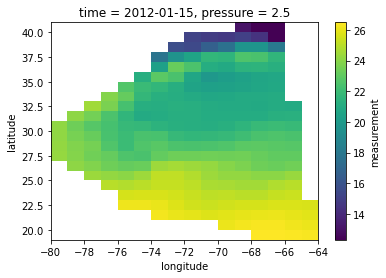

In [8]:
gridmap = ds.loc[{"time":'2012-01-15T00:00:00.000Z', "pressure":2.5}]
gridmap['measurement'].plot()

## Area-Weighted Means over a longitude/latitude region

A common operation when considering gridded data is to weight a mean by area of grid cells, which changes with latitude. A helper to do this with Argovis grid data could look like the following.

In [9]:
def areaweighted_region_mean(dxr):
    # given an xarray dataset <grid> for a given depth and time,
    # calculate the mean of the gridded data variable, weighted by grid cell area
    weights = np.cos(np.deg2rad(dxr.latitude))
    weights.name = "weights"
    dxr_weighted = dxr.weighted(weights)
    
    return dxr_weighted.mean(("longitude", "latitude"))

In [10]:
dxr_aw = areaweighted_region_mean(dxr=ds)
print(dxr_aw.loc[{"time":'2012-01-15T00:00:00.000Z', "pressure":2.5}])
dxr_aw

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    time         datetime64[ns] 2012-01-15
    pressure     float64 2.5
Data variables:
    measurement  float64 22.74


<xarray.Dataset>
Dimensions:      (time: 3, pressure: 58)
Coordinates:
  * time         (time) datetime64[ns] 2012-01-15 2012-02-15 2012-03-15
  * pressure     (pressure) float64 2.5 10.0 20.0 ... 1.8e+03 1.9e+03 1.975e+03
Data variables:
    measurement  (time, pressure) float64 22.74 22.74 22.75 ... 3.783 3.694

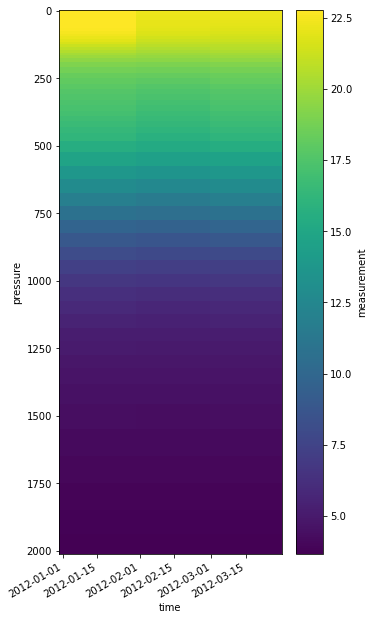

In [11]:
# Let's print the data after the spatial average over longitude and latitude
dxr_aw['measurement'].plot(y="pressure",yincrease=False,aspect=0.5, size=10)

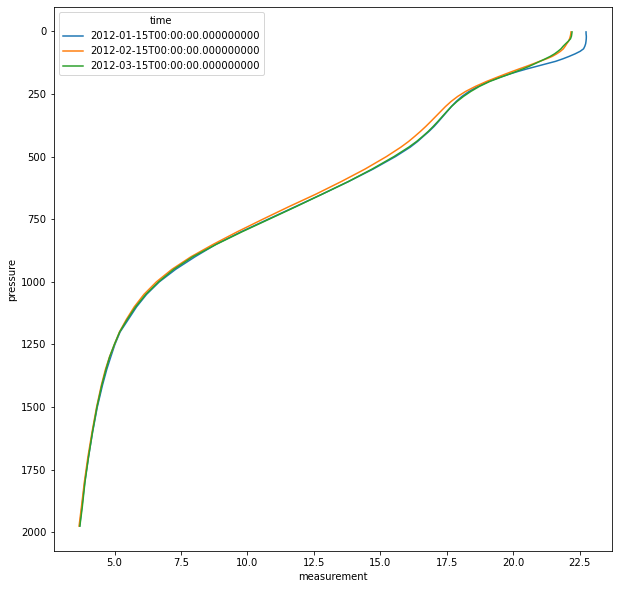

In [12]:
# Let's plot the data again, this time plotting one line per timestep
dxr_aw['measurement'].plot.line(y="pressure",yincrease=False,aspect=1, size=10)

## Accessing and visualizing Ocean Heat Content (OHC)

OHC fields in the following are by Kuusela and Giglio 2022 (https://doi.org/10.5281/zenodo.6131625) and are mapped using locally stationary Gaussian processes with data-driven decorrelation scales (Kuusela and Stein, 2018). A linear time trend was included in the estimate of the mean field (along with spatial terms and harmonics for the annual cycle). Mapping is done in latitude and longitude with monthly subsets of data for e.g. the 15-300 dbar pressure layer. The top layer of the pressure range is indicated in "levels".

In [13]:
params = {
  "gridName": 'ohc',
}

r = requests.get('https://argovis-api.colorado.edu/grids', params=params, headers={'x-argokey': API_KEY})
print(r.json())

{'_id': 'ohc', 'units': 'J/m^2', 'levels': [15], 'date_added': '2022-04-27T23:08:49.651Z', 'lonrange': [-179.5, 179.5], 'latrange': [-64.5, 64.5], 'timerange': ['2005-01-31T00:00:00.000Z', '2020-12-31T00:00:00.000Z'], 'loncell': 1, 'latcell': 1}


In [14]:
params = {
  "gridName": 'ohc',
  "startDate": '2012-01-01T00:00:00Z',
  "endDate": '2013-01-01T00:00:00Z',
  "polygon": '[[-78,30],[-70,30],[-70,20],[-78,20],[-78,30]]'
}

r = requests.get('https://argovis-api.colorado.edu/grids', params=params, headers={'x-argokey': API_KEY})
rgdata_ohc = r.json()

In [15]:
ds_ohc = xargrid(rgdata_ohc)

In [16]:
ds_ohc

<xarray.Dataset>
Dimensions:      (latitude: 10, longitude: 8, time: 12, pressure: 1)
Coordinates:
  * latitude     (latitude) float64 20.5 21.5 22.5 23.5 ... 26.5 27.5 28.5 29.5
  * longitude    (longitude) float64 -77.5 -76.5 -75.5 ... -72.5 -71.5 -70.5
  * time         (time) datetime64[ns] 2012-01-31 2012-02-29 ... 2012-12-31
  * pressure     (pressure) int64 15
Data variables:
    measurement  (latitude, longitude, time, pressure) float64 nan ... 3.439e+11

Let's plot a map of OHC for January 2012:

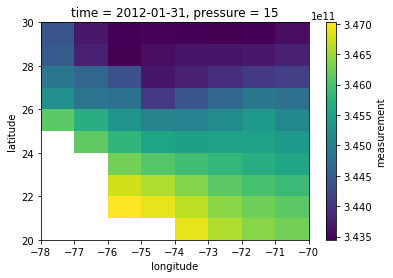

In [17]:
gridmap = ds_ohc.loc[{"time":'2012-01-31T00:00:00.000Z',"pressure":15}]
gridmap['measurement'].plot()

Let's now compute the area average in the selected region.

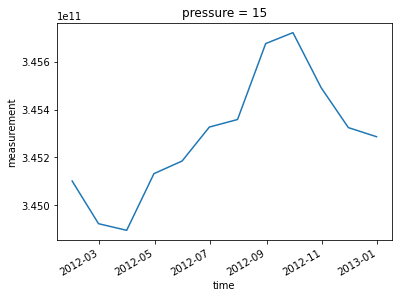

In [18]:
dxr_aw_ohc = areaweighted_region_mean(dxr=ds_ohc)
dxr_aw_ohc['measurement'].plot()